## Import

In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

이 코드는 입력으로 주어진 이진 마스크를 RLE 알고리즘을 사용하여 압축하는 함수를 정의한 것입니다. RLE 압축은 연속적으로 반복되는 값을 효과적으로 저장하고 전송하기 위해 사용됩니다. 이 함수는 입력 마스크를 압축된 문자열로 반환합니다.

In [2]:
# RLE 인코딩 함수
# RLE(Run-Length Encoding)은 연속적으로 반복되는 값을 압축하는 방법 중 하나입니다.

def rle_encode(mask):
    # 입력된 이진 마스크를 1차원 배열로 변환합니다.
    pixels = mask.flatten()

    # 배열의 시작과 끝에 0을 추가하여 RLE 알고리즘을 적용하기 위한 기본 준비를 합니다.
    pixels = np.concatenate([[0], pixels, [0]])

    # 연속하지 않는 값의 인덱스를 찾아내어 압축합니다.
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    # 압축된 런 길이를 계산합니다.
    runs[1::2] -= runs[::2]

    # 압축된 런을 문자열로 변환하여 반환합니다.
    return ' '.join(str(x) for x in runs)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/open

/content/drive/MyDrive/open


In [5]:
#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

#현재 파일의 폴더 경로; 작업 파일 기준
# print(os.path.dirname(os.path.realpath(__file__)))

/content/drive/MyDrive/open


## Custom Dataset

이 코드는 사용자 정의 데이터셋 클래스인 CustomDataset을 정의한 것으로, 주어진 CSV 파일에서 이미지와 마스크를 로드하고, 데이터 변환을 적용하는 역할을 합니다. 데이터셋의 용도에 따라 훈련 또는 추론(inference) 모드로 사용할 수 있습니다.

In [6]:
# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        # 주어진 CSV 파일을 읽어 데이터를 로드합니다.
        self.data = pd.read_csv(csv_file)

        # 데이터 변환(transform) 및 추론 모드 여부(infer)를 설정합니다.
        self.transform = transform
        self.infer = infer

    def __len__(self):
        # 데이터셋의 길이를 반환합니다.
        return len(self.data)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)를 사용하여 이미지 및 마스크 파일 경로를 가져옵니다.
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            # 추론 모드(infer)인 경우, 이미지 변환(transform)을 적용하고 이미지만 반환합니다.
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_path = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 마스크 이미지에서 픽셀 값이 255인 부분을 12로 간주하여 변경합니다.
        mask[mask == 255] = 12

        if self.transform:
            # 훈련 또는 검증 모드인 경우, 이미지와 마스크에 변환을 적용합니다.
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 이미지와 마스크를 반환합니다.
        return image, mask

## Data Loader

이 코드는 데이터 변환 파이프라인(transform)을 설정하고, 이 파이프라인을 사용하여 사용자 정의 데이터셋(CustomDataset)을 생성한 다음, 데이터로더(DataLoader)를 설정하는 부분입니다. 주로 훈련용 데이터셋을 미니배치로 나누고, 데이터를 섞어서 모델 훈련에 사용합니다. 이 파이프라인에서는 이미지를 224x224 크기로 조정하고, 정규화를 적용하여 이미지를 PyTorch 텐서로 변환합니다.

In [7]:
# 데이터 변환 파이프라인을 설정합니다. 이 파이프라인은 이미지에 대한 전처리 작업을 정의합니다.
#albumentations를 A로 두고 transform사용 -> albumentations는 torchvision보다 더 다양하고 빠른 모델임..
transform = A.Compose(

    [
        # 이미지를 224x224 크기로 조정합니다.
        A.Resize(224, 224),

        # 이미지를 정규화합니다. (평균과 표준편차를 사용하여 스케일링)
        A.Normalize(),

        # 이미지를 PyTorch 텐서로 변환합니다.
        ToTensorV2()
    ]
)

# 사용자 정의 데이터셋을 생성합니다.
# 위에서 정의한 transform을 집어넣어서 CustomDataset 클래스를 돌려서 데이터셋에 대한 처리를 해줌.
dataset = CustomDataset(csv_file='train_source.csv', transform=transform)

# 데이터로더를 설정합니다.
# 위에서 처리한 dataset을 DataLoader에 집어넣음.(DataLoader는 import시킨 라이브러리)
# batch_size는 데이터로더가 한 번에 로드하는 데이터 샘플의 수를 지정
# num_workers는 데이터를 로드하는 데 병렬로 작업을 수행할 프로세스(worker)의 수
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define Model

이 코드는 U-Net 아키텍처를 정의하는 파이토치 모델인 UNet 클래스를 구현한 것입니다. U-Net은 이미지 세그멘테이션 작업에 자주 사용되는 아키텍처 중 하나로, 다운샘플링과 업샘플링을 통해 이미지 내의 객체를 세그멘트하는 데 사용됩니다. Double Convolution Block은 U-Net의 핵심 구성 요소 중 하나이며, 이미지의 특징을 추출하기 위해 두 번의 컨볼루션 연산을 적용합니다. forward 메서드에서는 다운샘플링과 업샘플링을 수행하고 스킵 연결을 통합하여 최종 예측을 생성합니다.

In [8]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
# Double Convolution Block은 두 번의 컨볼루션(Convolution) 연산을 포함하는 블록입니다.
# double_conv는 첫번째 conv에서 기본적인 특징을 추출한 뒤(간단한 형태와 패턴)
# 두번째 conv에서 첫번째 레이어의 출력을 입력으로 받아서 고수준의 특징을 추출함.
# 게다가 첫번째 conv를 거친 뒤 relu함수로 비선형성을 추가한 뒤에 두번째 conv로 넘기기 때문에
# 더 복잡한 패턴을 포착할 수 있음.
# 이를 응용해서 triple_conv, fourth_conv도 만들 수는 있지만, 과적합, 연산과다 등이 우려될 수 있음.

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # 3x3 크기의 컨볼루션 연산, 입력 채널에서 출력 채널로 변환
        nn.ReLU(inplace=True),  # ReLU 활성화 함수
        nn.Conv2d(out_channels, out_channels, 3, padding=1),  # 다시 3x3 크기의 컨볼루션 연산
        nn.ReLU(inplace=True)  # ReLU 활성화 함수
    )


U-net의 구조


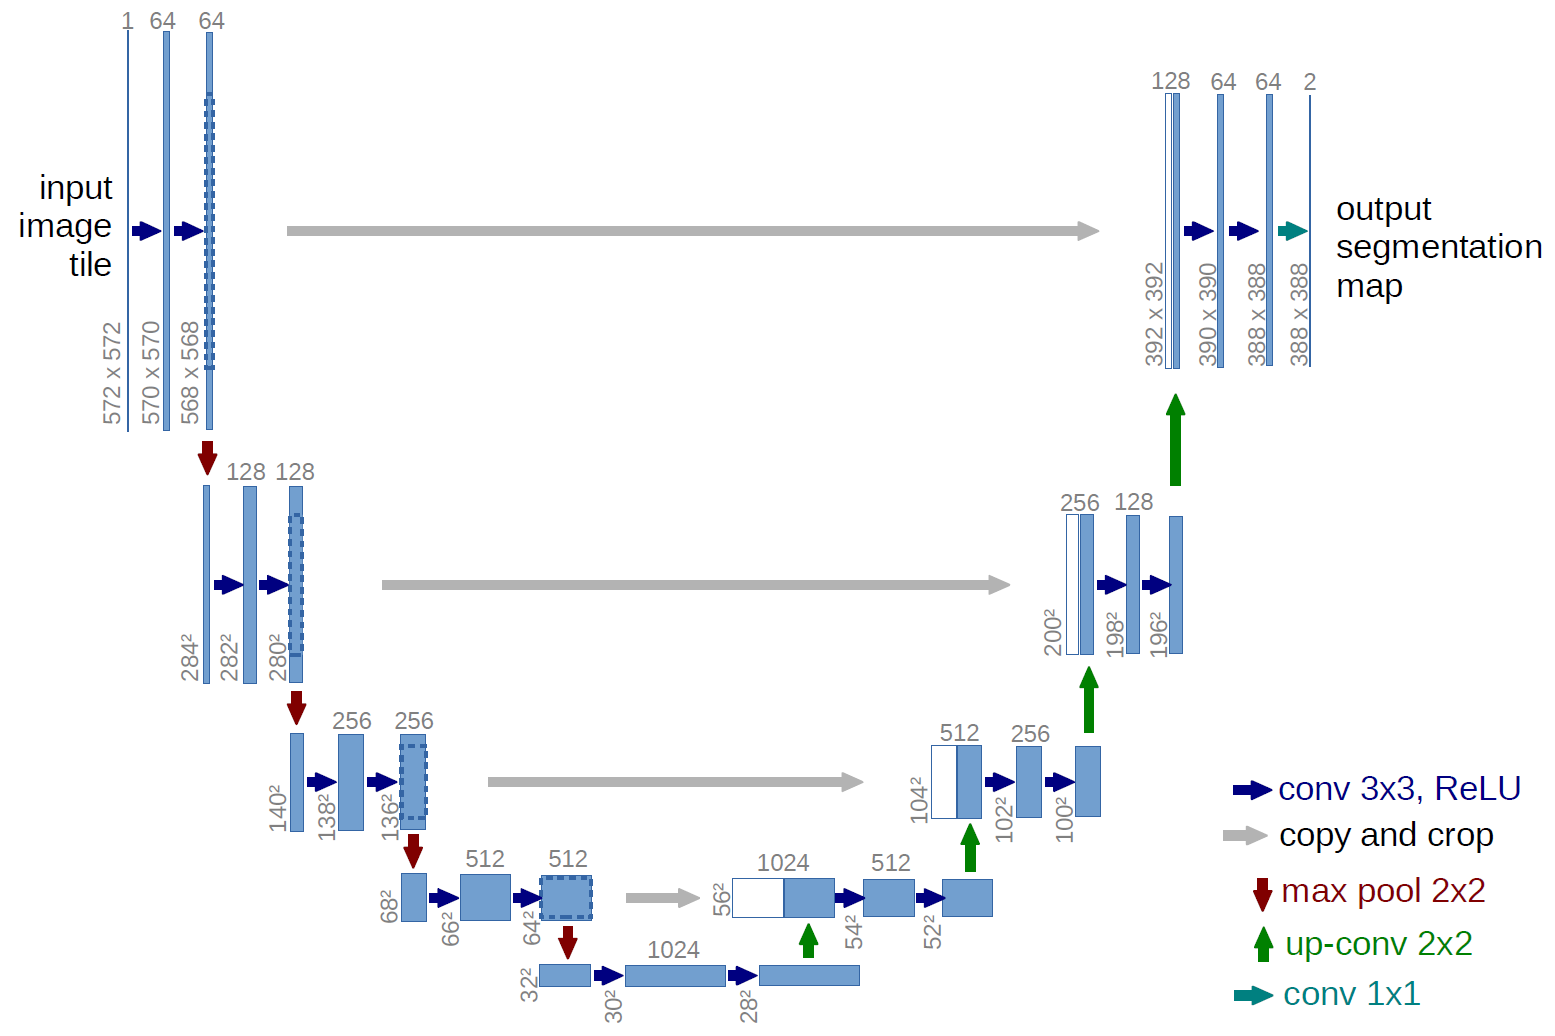

In [9]:

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # U-Net의 다운샘플링(downsampling) 단계 정의
        # 위에서 정의한 double_conv를 4단계 거치도록 설정
        # 위 사진에서의 구조에 따라 RGB 3개의 채널로 구성된 사진을 double conv를 거쳐 두번씩 3->64->128->256->512 의 채널로 늘려가며 특징 추출
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        # 맥스 풀링(MaxPooling)과 업샘플링(Upsampling) 레이어 정의
        # 위 과정에서 처럼 encoder 과정에서는 double_conv가 끝나고 maxpool을 거칠 것이고, decoder과정에서는 upsample링 과정을 거칠 것임.
        #**********************핵심********************
        # 즉 (double_conv->maxpool)*4 -> (Upsample->dconv_up)*4-> conv2d 의 과정을 거쳐 학습 과정 완료..
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # U-Net의 업샘플링(upsampling) 단계 정의
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        # 최종 출력 레이어 정의
        self.conv_last = nn.Conv2d(64, 13, 1)  # 12개 클래스 + 1 배경 클래스를 갖는 출력 레이어

    def forward(self, x):
        # 다운샘플링 단계 수행
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # 업샘플링 및 스킵 연결(concatenation) 수행
        # 이게 무슨 말이냐 하면 사진에서 보이는 회색 화살표들이 skip connection임.
        # "long skip connection을 사용하는 경우는, 보통 subsequent layer(후속, 뒤에 나오는 레이어)가 middle representation
        # (중간 레이어가 가지는 feature)를 재 사용해서, coarse한 정보 (공간적인 정보)를 얻기를 원할 때 이다. (feature re-use)"
        # 출처 : https://at0z.tistory.com/164
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        # 최종 출력 레이어를 통해 예측 결과 반환
        x = self.dconv_up1(x)
        out = self.conv_last(x)

        return out

## Model Train

이 코드는 U-Net 모델을 초기화하고, Cross Entropy 손실 함수와 Adam 옵티마이저를 설정한 후, 20 에폭 동안 모델을 훈련하는 학습 루프를 나타냅니다. 학습 루프에서는 각 미니배치를 사용하여 모델을 업데이트하고, 각 에폭의 손실을 출력합니다. 이를 통해 모델이 훈련 데이터에 대해 어떻게 학습되고 있는지를 모니터링할 수 있습니다.

In [10]:
# model 초기화
model = UNet().to(device)  # U-Net 모델을 생성하고 GPU(CUDA)에 모델을 로드합니다.

# loss function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss()  # Cross Entropy 손실 함수를 정의합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저를 정의하고 모델의 파라미터를 최적화합니다.

# training loop
for epoch in range(2):  # 20 에폭 동안 학습을 반복합니다.
    model.train()  # 모델을 학습 모드로 설정합니다.
    epoch_loss = 0  # 현재 에폭의 손실을 저장할 변수를 초기화합니다.

    for images, masks in tqdm(dataloader):  # 데이터로더를 이용하여 미니배치 단위로 데이터를 가져옵니다.
                                            # 미니 배치 단위는 위에서 dataloader로 설정한 (dataset, batch_size=16, shuffle=True, num_workers=4)
        images = images.float().to(device)  # 이미지 데이터를 GPU로 전송합니다.
        masks = masks.long().to(device)  # 마스크 데이터를 GPU로 전송합니다.

        optimizer.zero_grad()  # 기존 그라디언트를 초기화합니다.
        outputs = model(images)  # 모델에 이미지를 전달하여 예측을 수행합니다.
        loss = criterion(outputs, masks.squeeze(1))  # 예측과 실제 마스크 사이의 손실을 계산합니다.

        loss.backward()  # 역전파를 수행하여 그라디언트를 계산합니다.
        optimizer.step()  # 옵티마이저를 사용하여 모델 파라미터를 업데이트합니다.

        epoch_loss += loss.item()  # 현재 미니배치의 손실을 누적합니다.

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')  # 현재 에폭의 평균 손실을 출력합니다.

100%|██████████| 7/7 [08:26<00:00, 72.32s/it]


Epoch 1, Loss: 2.626389878136771


100%|██████████| 7/7 [08:00<00:00, 68.64s/it]

Epoch 2, Loss: 2.2705611331122264


## Inference

이 코드는 테스트 데이터셋을 생성하고, 테스트 데이터로더를 설정하는 부분입니다.

CustomDataset 클래스를 사용하여 테스트 데이터셋을 생성합니다. csv_file 매개변수를 통해 테스트 데이터의 경로를 지정하고, 이미지 변환(transform) 및 추론 모드(infer=True)를 설정합니다. 추론 모드에서는 마스크 정보를 필요로하지 않고 이미지만 반환합니다.

DataLoader를 사용하여 테스트 데이터로더를 설정합니다. batch_size는 한 번에 로드할 데이터 샘플 수를 지정하며, 여기서는 16으로 설정되어 있습니다. shuffle 매개변수는 데이터를 섞을지 여부를 나타내며, 테스트 시에는 False로 설정하여 데이터를 섞지 않습니다. num_workers는 데이터 로딩에 사용할 병렬 프로세스(worker)의 수를 나타냅니다. 여기서는 4개의 프로세스가 동시에 작업을 수행하여 데이터 로딩 속도를 향상시킵니다.

In [11]:
# 테스트 데이터셋을 생성합니다.
# 위에서 train 데이터셋을 생성할 때와는 달리 infer을 True로 두고 infer 과정을 거치도록 생성.
# infer 과정을 거치느냐 안거치느냐의 차이점은
# 추론 모드(infer)인 경우, 이미지 변환(transform)을 적용하고 이미지만 반환함.
# 즉 train에서는 일반적인 사진과 mask처리된 사진(정답지)를 주고 학습을 시켰다면 test에서는 정답지를 추론해야 하므로 다르게 처리.
test_dataset = CustomDataset(csv_file='./test.csv', transform=transform, infer=True)


# 테스트 데이터로더를 설정합니다.
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


이 코드는 테스트 데이터셋을 사용하여 모델의 예측을 수행하고, 예측된 마스크를 RLE 인코딩하여 결과를 저장하는 부분입니다. 주요 단계는 다음과 같습니다:

torch.no_grad() 블록 내에서 그라디언트 계산을 비활성화하고, 모델을 평가 모드로 설정합니다.

테스트 데이터로더(test_dataloader)에서 이미지를 미니배치 단위로 가져오고, 이를 모델(model)에 전달하여 예측(outputs)을 얻습니다.

예측된 확률 분포를 소프트맥스 확률로 변환하고, 가장 높은 확률을 가진 클래스를 선택하여 예측값을 생성합니다.

각 이미지의 예측 결과에 대해서 반복하면서, 각 클래스에 대한 마스크를 형성하고 RLE 인코딩을 수행합니다.

마스크가 존재하지 않는 경우, -1을 결과 리스트에 추가합니다.

이러한 과정을 통해 테스트 데이터에 대한 예측된 마스크를 RLE 인코딩하여 결과 리스트에 저장합니다.

In [12]:
# 테스트 시 그라디언트 계산을 비활성화합니다.
with torch.no_grad():
    model.eval()  # 모델을 평가 모드로 설정합니다.
    result = []  # 결과를 저장할 리스트를 초기화합니다.

    # 테스트 데이터로더를 반복합니다.
    for images in tqdm(test_dataloader):
        images = images.float().to(device)  # 이미지 데이터를 GPU로 전송합니다.
        outputs = model(images)  # 모델을 사용하여 예측을 수행합니다.
        outputs = torch.softmax(outputs, dim=1).cpu()  # 소프트맥스 확률을 계산하고 CPU로 이동합니다.
        outputs = torch.argmax(outputs, dim=1).numpy()  # 가장 높은 확률을 가진 클래스를 선택하고 NumPy 배열로 변환합니다.

        # batch에 존재하는 각 이미지에 대해서 반복합니다.
        for pred in outputs:
            pred = pred.astype(np.uint8)  # 예측값을 부호 없는 8비트 정수로 변환합니다.
            pred = Image.fromarray(pred)  # NumPy 배열을 이미지로 변환합니다.
            pred = pred.resize((960, 540), Image.NEAREST)  # 이미지 크기를 960 x 540으로 조정합니다.

            pred = np.array(pred)  # 이미지를 다시 NumPy 배열로 변환합니다.

            ## UNet 모델의 마지막 레이어인 self.conv_last의 출력 채널 수를 확인합니다.

            # class 0 ~ 11에 해당하는 경우에 마스크를 형성하고 인코딩합니다.
            # 12(배경)는 제외하고 진행합니다.
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)  # 클래스에 해당하는 픽셀을 추출합니다.
                if np.sum(class_mask) > 0:  # 마스크가 존재하는 경우에만 인코딩합니다.
                    mask_rle = rle_encode(class_mask)  # RLE 인코딩을 수행합니다.
                    result.append(mask_rle)  # 결과 리스트에 추가합니다.
                else:  # 마스크가 존재하지 않는 경우 -1을 추가합니다.
                    result.append(-1)

100%|██████████| 7/7 [02:50<00:00, 24.36s/it]


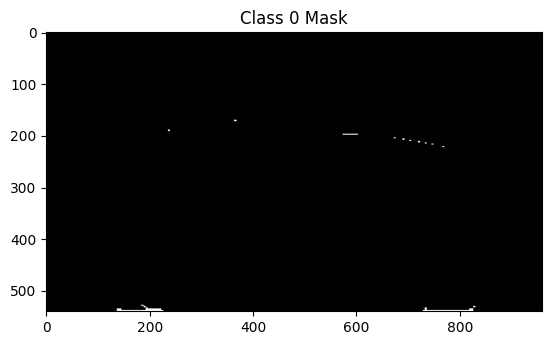

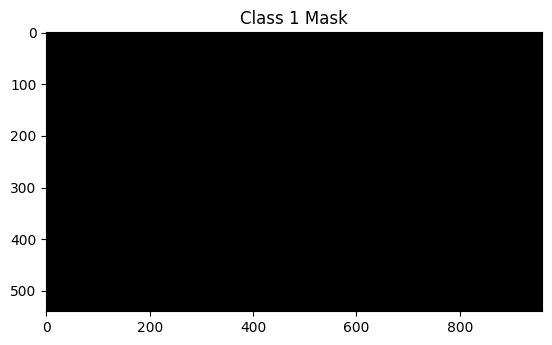

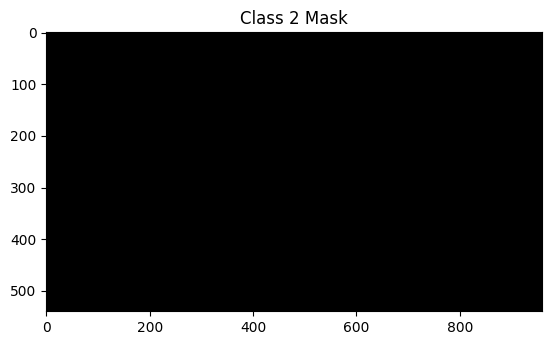

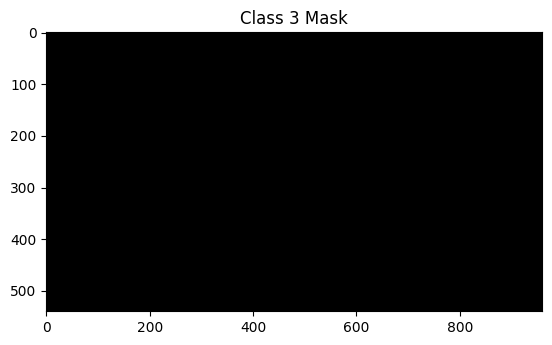

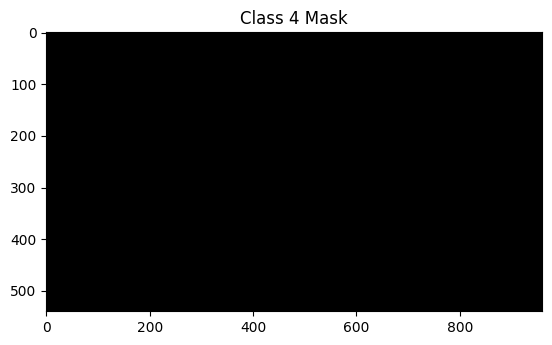

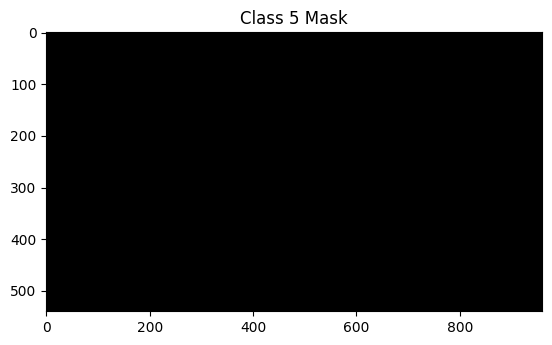

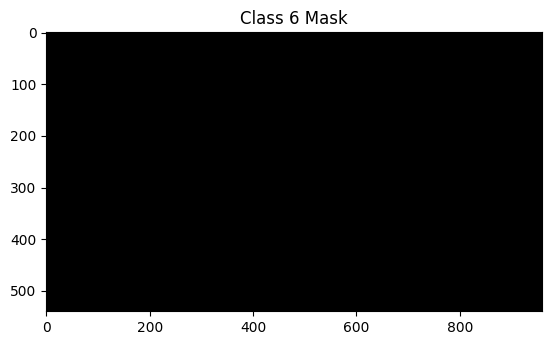

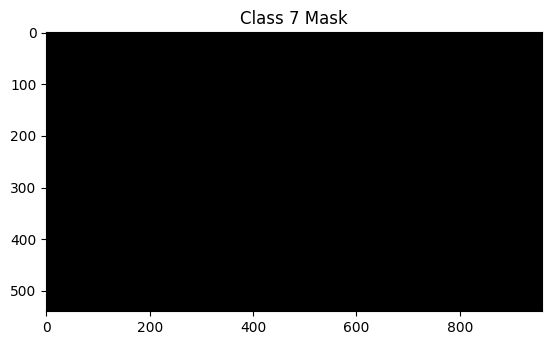

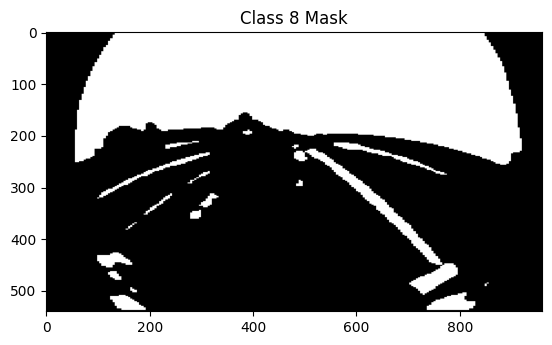

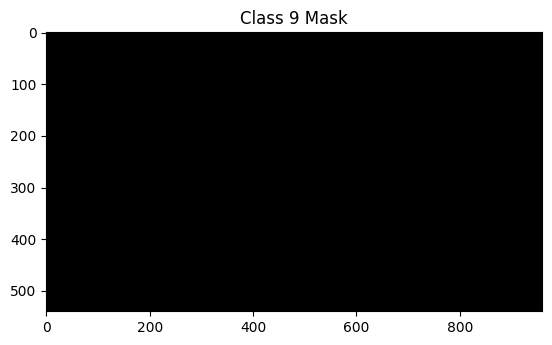

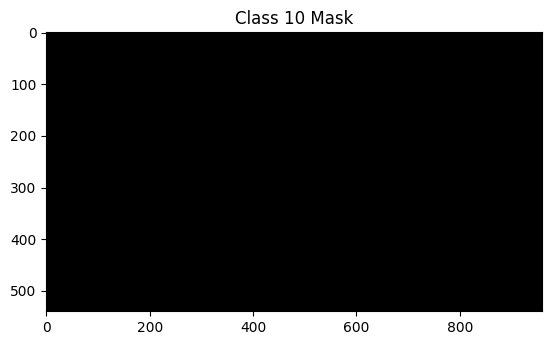

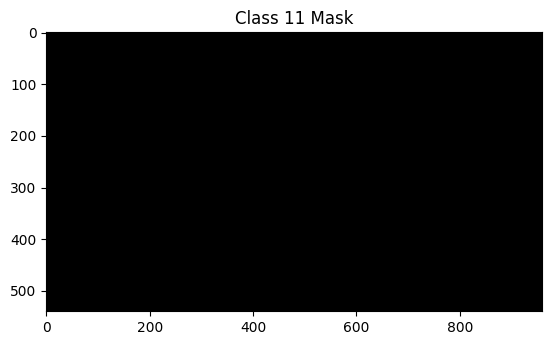

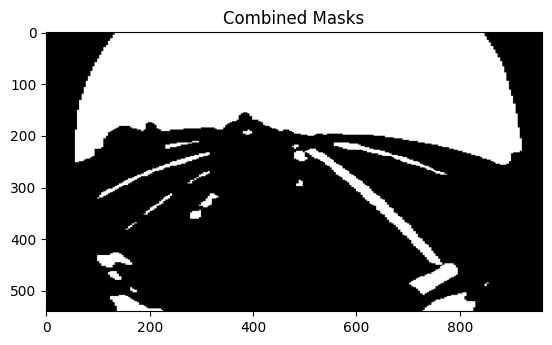

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ... (이전 코드 부분은 그대로 유지)

# 각 클래스의 마스크를 리스트에 저장합니다.
class_masks = []
for class_id in range(12):
    class_mask = (pred == class_id).astype(np.uint8)  # 클래스에 해당하는 픽셀을 추출합니다.
    class_masks.append(class_mask)

    # 각 클래스의 마스크를 시각화합니다.
    plt.imshow(class_mask, cmap='gray')
    plt.title(f'Class {class_id} Mask')
    plt.show()

# 모든 클래스의 마스크를 합쳐서 출력합니다.
combined_mask = np.stack(class_masks, axis=-1).sum(axis=-1)
plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Masks')
plt.show()

## Submission

이 코드는 테스트 데이터에 대한 모델의 예측 결과를 제출용 데이터프레임에 추가하는 부분입니다.

'./sample_submission.csv' 파일은 제출 양식의 템플릿으로 사용됩니다. 이 파일을 pd.read_csv() 함수로 읽어와서 submit 데이터프레임에 저장합니다.

result 리스트에는 이전 코드에서 계산한 RLE 인코딩된 마스크 정보가 포함되어 있습니다.

'mask_rle' 열에 result 리스트의 내용을 추가하여 제출용 데이터프레임을 업데이트합니다.

최종적으로 submit 데이터프레임을 출력하면, 예측된 마스크 정보가 포함된 제출용 데이터프레임이 생성됩니다. 이를 이용하여 모델의 예측 결과를 제출할 수 있습니다.

In [13]:
# './sample_submission.csv' 파일을 읽어옵니다. 이 파일은 제출용 템플릿으로 사용됩니다.
submit = pd.read_csv('./sample_submission.csv')

# 'mask_rle' 열에 예측 결과를 추가합니다. 'result' 리스트에는 RLE 인코딩된 마스크 정보가 담겨 있습니다.
submit['mask_rle'] = result

# 최종 제출용 데이터프레임을 반환합니다. 'mask_rle' 열에는 모델의 예측 결과가 저장됩니다.
submit

,id,mask_rle
0,TEST_0000_class_0,222190 4 223150 4 224110 4 233637 4 234597 4 2...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,-1
3,TEST_0000_class_3,-1
4,TEST_0000_class_4,-1
...,...,...
1195,TEST_0099_class_7,-1
1196,TEST_0099_class_8,130 728 1090 728 2054 716 3014 716 3974 716 49...
1197,TEST_0099_class_9,-1
1198,TEST_0099_class_10,-1


이 코드는 submit 데이터프레임을 CSV 파일로 저장하는 부분입니다. to_csv() 함수를 사용하여 데이터프레임을 CSV 형식으로 저장하며, 저장될 파일의 경로와 이름은 './baseline_submit.csv'로 지정되어 있습니다. index=False 옵션은 데이터프레임의 인덱스를 저장하지 않도록 설정합니다. 이렇게 저장된 CSV 파일은 모델의 예측 결과를 포함하고 있으며, 이를 제출할 수 있습니다.

In [14]:
# 'submit' 데이터프레임을 CSV 파일로 저장합니다.
# './baseline_submit.csv'는 저장할 CSV 파일의 경로와 이름을 나타냅니다.
# 'index=False'는 데이터프레임의 인덱스를 저장하지 않도록 설정합니다.
submit.to_csv('./baseline_submit.csv', index=False)